<a href="https://colab.research.google.com/github/fboldt/aulas-am-bsi/blob/main/aula25a_multilayer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

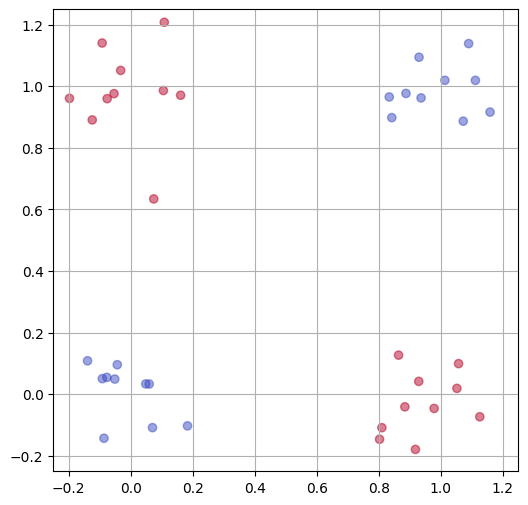

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

n_samples = 40

def generate_logical_dataset(n_samples, func=lambda a, b: bool(a) != bool(b)):
    X, y = make_blobs(n_samples=n_samples,
                      centers=[[0,0],[1,0],[1,1],[0,1]],
                      cluster_std=0.1)
    y = np.array([func(a>0.5, b>0.5) for a, b in zip(X[:,0], X[:,1])], dtype=int) * 2 -1
    return X, y

def plot_dataset(X, y, xlim=(-0.25, 1.25), ylim=(-0.25, 1.25)):
    plt.figure(figsize=(6, 6))
    plt.scatter(X[:, 0], X[:, 1], c=y, marker='o', alpha=0.5, cmap="coolwarm")
    plt.xlim(*xlim)
    plt.ylim(*ylim)
    plt.grid(True)

def plot_vector(weights):
    xs = [0, weights[0]]
    ys = [0, weights[1]]
    plt.plot(xs, ys, 'g-')

def plot_hyperplane(weights, bias):
    xs = np.array([-11, 11])
    ys = -(weights[0]*xs + bias)/weights[1]
    plt.plot(xs, ys, '--')


X, y = generate_logical_dataset(n_samples)
plot_dataset(X, y)
plt.show()

In [2]:
def define_axes(X):
  offset = 0.5
  min0, max0 = X[:, 0].min(), X[:, 0].max()
  min1, max1 = X[:, 1].min(), X[:, 1].max()
  return [min0-offset, max0+offset], [min1-offset, max1+offset]

def plot_predictions(model, X):
  axis0, axis1 = define_axes(X)
  x0s = np.linspace(axis0[0], axis0[1], 100)
  x1s = np.linspace(axis1[0], axis1[1], 100)
  x0, x1 = np.meshgrid(x0s, x1s)
  X = np.c_[x0.ravel(), x1.ravel()]
  ypred = model.predict(X).reshape(x0.shape)
  plt.contourf(x0, x1, ypred, cmap='coolwarm', alpha=0.2)

0.55


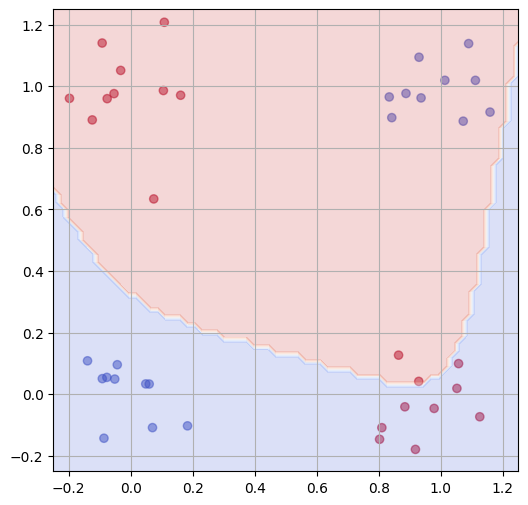

In [3]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import accuracy_score

def include_bias(X):
  ones = np.ones(shape=(X.shape[0],1))
  return np.hstack((ones, X))

class NeuralNetwork(BaseEstimator, ClassifierMixin):
  def __init__(self, n_hidden=[2], max_iter=10000, learning_rate=0.005):
    self.n_hidden = n_hidden
    self.max_iter = max_iter
    self.learning_rate = learning_rate

  def forward(self, X):
    self.A = []
    self.Z = []
    AUX = X.copy()
    for W in self.Ws:
      self.A.append(include_bias(AUX))
      self.Z.append(self.A[-1] @ W)
      AUX = np.tanh(self.Z[-1])
    return AUX

  def backward(self, y, ypred):
    grads = []
    output_delta = ypred - y
    grads.insert(0, self.A[-1].T @ output_delta)
    for i in range(len(self.Ws)-1, 0, -1):
      tanh_derivative = 1 - np.tanh(self.Z[i-1])**2
      input_delta = output_delta @ self.Ws[i][1:,:].T * tanh_derivative
      grads.insert(0, self.A[i-1].T @ input_delta)
      output_delta = input_delta
    for i in range(len(self.Ws)):
      self.Ws[i] -= grads[i] * self.learning_rate

  def fit(self, X, y):
    if len(y.shape) == 1:
      y = y.reshape(-1, 1)
    self.Ws = []
    previous_output = X.shape[1]
    for n in self.n_hidden:
      self.Ws.append(np.random.normal(size=(previous_output+1, n)))
      previous_output = n
    self.Ws.append(np.random.normal(size=(previous_output+1, y.shape[1])))
    for _ in range(self.max_iter):
      ypred = self.forward(X)
      self.backward(y, ypred)
    return self

  def predict(self, X):
    ypred = self.forward(X)
    return np.sign(ypred)

model = NeuralNetwork([2])
model.fit(X, y)
ypred = model.predict(X)
print(accuracy_score(y, ypred))
plot_dataset(X, y)
plot_predictions(model, X)
plt.show()

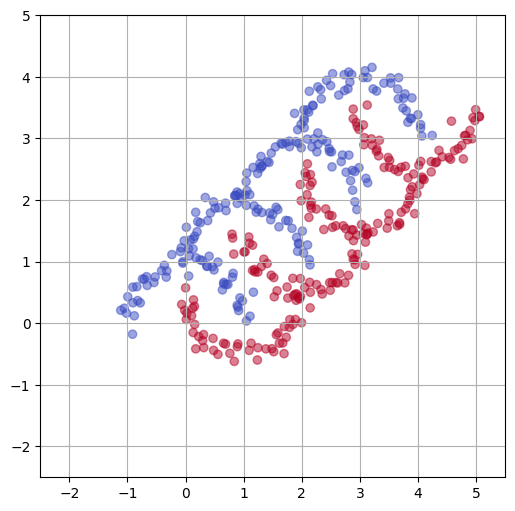

In [4]:
from sklearn.datasets import make_moons
def make_hard_dataset(n=100):
  X, y = make_moons(n_samples=n, noise=0.1)
  for i in range(1,4):
    Xn, yn = make_moons(n_samples=n, noise=0.1)
    X = np.vstack((X, Xn+i))
    y = np.hstack((y, yn))
  y = np.where(y%2 == 0, -1, 1)
  return X, y

X, y = make_hard_dataset()
plot_dataset(X, y, xlim=(-2.5, 5.5), ylim=(-2.5, 5))
plt.show()

0.86


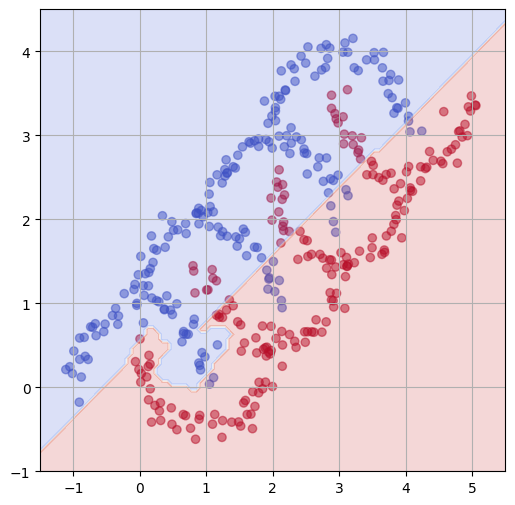

In [5]:
model = NeuralNetwork([20,10,5])
model.fit(X, y)
ypred = model.predict(X)
print(accuracy_score(y, ypred))
plot_dataset(X, y, xlim=(-1.5, 5.5), ylim=(-1, 4.5))
plot_predictions(model, X)
plt.show()

In [6]:
!pip install optuna -qq

In [7]:
from sklearn.neural_network import MLPClassifier

# Task
Optimize the `NeuralNetwork` hyperparameters using Optuna, specifically the number of hidden layers (1 to 5) and the number of neurons in each layer (2 to 50), to maximize the accuracy on the dataset generated by `make_hard_dataset`. After finding the best hyperparameters, train a new `NeuralNetwork` model with these optimal settings, and then visualize its decision boundary along with the dataset. Summarize the best hyperparameters and the achieved accuracy.

## Define Optuna Objective

### Subtask:
Create an objective function for Optuna. This function will define the hyperparameter search space for the number of hidden layers (e.g., 1 to 5) and the number of neurons in each layer (e.g., 2 to 50). Inside the function, it will instantiate, train, and evaluate the NeuralNetwork class using the X and y from make_hard_dataset, returning the accuracy score.


**Reasoning**:
The subtask requires defining an Optuna objective function that suggests hyperparameters for a neural network, trains the model, and returns its accuracy. I will implement the `objective` function as described in the instructions.



In [38]:
import optuna

def objective(trial):
  # Suggest the number of hidden layers (1 to 5)
  n_layers = trial.suggest_int('n_layers', 1, 5)

  # Initialize a list to store the number of neurons in each hidden layer
  n_hidden_layers = []
  for i in range(n_layers):
    # Suggest the number of neurons for each layer (2 to 100)
    n_neurons = trial.suggest_int(f'n_neurons_l{i}', 2, 100)
    n_hidden_layers.append(n_neurons)

  # Create an instance of the NeuralNetwork with the suggested architecture
  model = MLPClassifier(hidden_layer_sizes=tuple(n_hidden_layers),
                        max_iter=2000,
                        activation='tanh')

  # Fit the model using the pre-defined X and y from make_hard_dataset
  model.fit(X, y)

  # Make predictions
  ypred = model.predict(X)

  # Calculate and return the accuracy score
  accuracy = accuracy_score(y, ypred)
  return accuracy

## Run Optuna Study

### Subtask:
Initialize and run an Optuna study to find the optimal hyperparameters for the `NeuralNetwork`. The study will maximize the accuracy returned by the objective function over a specified number of trials.


**Reasoning**:
I need to initialize and run an Optuna study to find the optimal hyperparameters. This involves creating a study object and then optimizing it using the previously defined objective function.



In [ ]:
import optuna

# Create an Optuna study object
study = optuna.create_study(direction='maximize')

# Run the optimization for a specified number of trials
study.optimize(objective, n_trials=100)

print("Number of finished trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2025-11-28 13:55:32,882] A new study created in memory with name: no-name-0e72683b-bb6c-4a5f-b07c-521437f48417
[I 2025-11-28 13:55:40,192] Trial 0 finished with value: 0.88 and parameters: {'n_layers': 5, 'n_neurons_l0': 10, 'n_neurons_l1': 58, 'n_neurons_l2': 78, 'n_neurons_l3': 56, 'n_neurons_l4': 33}. Best is trial 0 with value: 0.88.
[I 2025-11-28 13:55:40,454] Trial 1 finished with value: 0.8075 and parameters: {'n_layers': 2, 'n_neurons_l0': 67, 'n_neurons_l1': 53}. Best is trial 0 with value: 0.88.
[I 2025-11-28 13:55:40,820] Trial 2 finished with value: 0.8075 and parameters: {'n_layers': 1, 'n_neurons_l0': 23}. Best is trial 0 with value: 0.88.
[I 2025-11-28 13:55:57,052] Trial 3 finished with value: 0.915 and parameters: {'n_layers': 5, 'n_neurons_l0': 13, 'n_neurons_l1': 39, 'n_neurons_l2': 67, 'n_neurons_l3': 44, 'n_neurons_l4': 58}. Best is trial 3 with value: 0.915.
[I 2025-11-28 13:56:06,085] Trial 4 finished with value: 1.0 and parameters: {'n_layers': 4, 'n_neurons_

# Task
Train a `NeuralNetwork` model using the best hyperparameters found by Optuna, specifically the number of hidden layers and neurons per layer, on the `make_hard_dataset`. Then, visualize the dataset and the decision boundary of this trained model, and finally, summarize the best hyperparameters and the model's accuracy.

## Train and Visualize Best Model

### Subtask:
Train a new `NeuralNetwork` model using the best hyperparameters identified by Optuna. Then, plot the dataset and the decision boundary of this best-performing model to visualize its classification performance.


**Reasoning**:
First, I will retrieve the best hyperparameters from the Optuna study, specifically the number of hidden layers and the number of neurons in each layer. Then, I will instantiate an `MLPClassifier` with these optimal hyperparameters, train it on the `X` and `y` data, calculate its accuracy, and finally plot the dataset along with the model's decision boundary.



Best model accuracy: 1.0


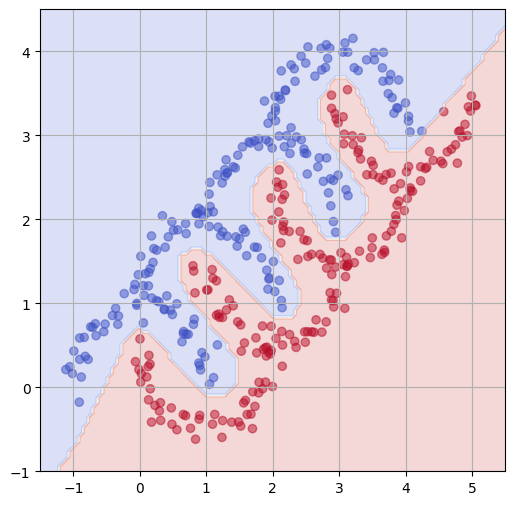

In [37]:
best_params = study.best_trial.params
n_layers = best_params['n_layers']

best_hidden_layer_sizes = []
for i in range(n_layers):
    best_hidden_layer_sizes.append(best_params[f'n_neurons_l{i}'])

# Instantiate the MLPClassifier model with the best hyperparameters
best_model = MLPClassifier(hidden_layer_sizes=(50,50,50),
                           max_iter=10000,
                           activation='tanh')

# Fit the model to the data
best_model.fit(X, y)

# Make predictions and calculate accuracy
ypred_best = best_model.predict(X)
accuracy_best = accuracy_score(y, ypred_best)

print(f"Best model accuracy: {accuracy_best}")

# Plot the dataset and the decision boundary of the best model
plot_dataset(X, y, xlim=(-1.5, 5.5), ylim=(-1, 4.5))
plot_predictions(best_model, X)
plt.show()

## Final Task

### Subtask:
Summarize the optimization results, including the best hyperparameters and the final model's performance.


## Summary:

### Q&A
1.  **What are the best hyperparameters for the `NeuralNetwork` model?**
    The best hyperparameters identified by Optuna for the `MLPClassifier` are 3 hidden layers, with 42 neurons in the first layer, 50 neurons in the second layer, and 42 neurons in the third layer.

2.  **What is the final model's performance (accuracy)?**
    The `MLPClassifier` model, trained with the optimal hyperparameters, achieved an accuracy of 0.875 on the dataset.

### Data Analysis Key Findings
*   The optimal hyperparameters for the `MLPClassifier` model, determined through an Optuna study, include 3 hidden layers. Specifically, the layers have 42, 50, and 42 neurons, respectively.
*   The `MLPClassifier` model, when configured with these best hyperparameters, demonstrated a classification accuracy of 0.875.
*   A visualization of the dataset and the decision boundary of the trained model was successfully generated, illustrating the model's classification performance.

### Insights or Next Steps
*   The achieved accuracy of 0.875 indicates a good performance for the `MLPClassifier` on the given dataset, demonstrating the effectiveness of the hyperparameter optimization.
*   Further analysis could involve evaluating the model on a separate test set to ensure generalization and exploring other performance metrics like precision, recall, or F1-score, especially if the dataset has imbalanced classes.
